In [1]:
dir_base = "./../../"

#### 1. Importação de bibliotecas

In [2]:
import os, shutil
from os import listdir, mkdir

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import pandas as pd

In [5]:
from PIL import Image
from PIL import ImageFilter
import cv2
import random

#### 2. Declaração de funções

In [6]:
def adiciona_padding():
    
    for pasta in listdir(dir_base+"mapas/"):
        for arquivo in listdir(dir_base+"mapas/"+pasta):
            
            imagem = cv2.imread(dir_base+"mapas/"+pasta+'/'+arquivo)
            imagem_convertida = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
            shape = imagem_convertida.shape
            add_x = int((224-shape[0])/2)
            add_y = int((224-shape[1])/2)
            mapa_distancias = np.zeros((224,224,3),dtype = np.uint8)
            for i in range(3):
                mapa_distancias[:,:,i] = np.pad(imagem_convertida[:,:,i],((add_x,add_x),(add_y,add_y)),'constant', constant_values = (0))
            
            plt.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
            
            plt.imsave(dir_base+"mapas/"+pasta+'/'+arquivo, mapa_distancias)
   
    return

In [7]:
def resize_maps():
    
    for pasta in listdir(dir_base+"mapas/"):
        for file in listdir(dir_base+"mapas/"+pasta):
    
            dm = cv2.imread(dir_base+"mapas/"+pasta+"/"+file)

            new_dm = cv2.resize(dm, (64, 64), interpolation= cv2.INTER_LINEAR)

            cv2.imwrite(dir_base+"mapas/"+pasta+"/"+file, new_dm)
    
    return

In [8]:
def aumento_brilho(file, pasta):
    
    dm = cv2.imread(dir_base+"mapas/"+pasta+"/"+file)
    
    nome_arquivo = file.split('.')[0]

    value = random.uniform(1.0, 1.2)
    hsv = cv2.cvtColor(dm, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    dm = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    cv2.imwrite(dir_base+"mapas/"+pasta+"/"+nome_arquivo+"_bi.png", dm)
    
    return

In [9]:
def decresce_brilho(file, pasta):
    
    dm = cv2.imread(dir_base+"mapas/"+pasta+"/"+file)
    
    nome_arquivo = file.split('.')[0]

    value = random.uniform(0.8, 1.0)
    hsv = cv2.cvtColor(dm, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    dm = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    cv2.imwrite(dir_base+"mapas/"+pasta+"/"+nome_arquivo+"_bd.png", dm)
    
    return

In [10]:
def filtro_sharpen(file, pasta):
    
    nome_arquivo = file.split('.')[0]
    
    obj = Image.open(dir_base+"mapas/"+pasta+"/"+file)
    im = obj.filter(ImageFilter.SHARPEN)

    im.save(dir_base+"mapas/"+pasta+"/"+nome_arquivo+"_shp.png")
    
    return

In [19]:
def data_augmentation():
    
    for pasta in listdir(dir_base+"mapas/"):
        for file in listdir(dir_base+"mapas/"+pasta):
            
            # 1. alteração do brilho
        
            # 1.1 aumento de intensidade
            aumento_brilho(file, pasta)
            
            # 1.2 decrescimento de intensidade
            decresce_brilho(file, pasta)            
            
            # 2. filtro de Sharpen
            filtro_sharpen(file, pasta)
            
    return

In [12]:
def calcula_distancias(coords_pep, coords_prot, classe, arquivo):
    
    nome_arquivo = arquivo.split('.')[0]
    
    x = np.shape(coords_prot)[0]
    y = np.shape(coords_pep)[0]

    m = np.zeros(shape=(y,x))
        
    i=0
    for a in coords_pep:
        m[i] = list(map(lambda b: np.linalg.norm(a-b), coords_prot))
        i+=1
    
    if not os.path.isdir(dir_base+'mapas/'+classe):
        mkdir(dir_base+'mapas/'+classe)
        
    plt.imsave(dir_base+'mapas/'+classe+'/'+nome_arquivo+'.png', m)
    
    return   

In [13]:
def ler_coordenadas():
    
    for pasta in listdir(dir_base+"pdbs/"):
        for file in listdir(dir_base+"pdbs/"+pasta):

            pdb = open(dir_base+"pdbs/"+pasta+"/"+file, "rt")
            linhas = pdb.readlines()

            # Peptídeo
            cadeia_pep = (file.split(".")[0]).split("_")[1]
            peptideo = list(filter(lambda l: l[13:15]=="CA" and l[21:22]==cadeia_pep, linhas))
            coords_pep = np.array(list(map(lambda ca: [float(ca[31:38]), float(ca[39:46]), float(ca[47:54])], peptideo)))

            # Proteína
            cadeia_prot = (file.split(".")[0]).split("_")[2]
            proteina = list(filter(lambda l: l[13:15]=="CA" and l[21:22]==cadeia_prot, linhas))
            coords_prot = np.array(list(map(lambda ca: [float(ca[31:38]), float(ca[39:46]), float(ca[47:54])], proteina)))

            calcula_distancias(coords_pep, coords_prot, pasta, file)
    
    return

In [14]:
def selecionar_interfaces():
      
    for pasta in listdir(dir_base+"interfaces/"):
        for file in listdir(dir_base+"interfaces/"+pasta):

            pdb = open(dir_base+"interfaces/"+pasta+"/"+file, "rt")
            linhas = pdb.readlines()

            # Peptídeo
            cadeia_pep = (file.split(".")[0]).split("_")[1]
            peptideo = list(filter(lambda l: l[13:15]=="CA" and l[21:22]==cadeia_pep, linhas))

            # Proteína
            cadeia_prot = (file.split(".")[0]).split("_")[2]
            proteina = list(filter(lambda l: l[13:15]=="CA" and l[21:22]==cadeia_prot, linhas))

            pdb.close()
            
            if not os.path.isdir(dir_base+'pdbs/'+pasta):
                mkdir(dir_base+'pdbs/'+pasta)
            
            if (len(peptideo)!=0 and len(proteina)!=0):
                shutil.move(os.path.join(dir_base,'interfaces',pasta,file),os.path.join(dir_base,'pdbs',pasta,file))
    
    return

In [15]:
def classificar_complexos_sc1():
    
    interfaces = listdir(dir_base+'complexos/')
        
    df = pd.read_csv(dir_base+'dados_experimento_1_cutoff_0_2_max_20.csv')
    
    for i in range(df[df.columns[0]].count()-1):
        
        classe = df[df.columns[0]][i].split('/')[1]
        peptideo = (df[df.columns[0]][i].split('/')[2]).split('.')[0]
        
        if not os.path.isdir(dir_base+'interfaces/'+classe):
            mkdir(dir_base+'interfaces/'+classe)
        
        files = list(filter(lambda x: peptideo in x, interfaces))

        for f in files:
            if os.path.isfile(os.path.join(dir_base,'complexos',f)):
                shutil.move(os.path.join(dir_base,'complexos',f), os.path.join(dir_base,'interfaces',classe,f))
                interfaces.remove(f)
    
    return

In [ ]:
def classificar_complexos_sc2():
    
    interfaces = listdir(dir_base+'complexos/')
        
    df = pd.read_csv(dir_base+'dados_experimento_2_cutoff_0_2_max_20.csv')
    
    for i in range(df.cluster.count()-1):

        classe = df['cluster'][i]
        peptideo = df['peptide'][i].split(' ')[1].replace('(','').replace(')','').replace(':','_')

        if not os.path.isdir(dir_base+'interfaces/'+classe):
            mkdir(dir_base+'interfaces/'+classe)

        files = list(filter(lambda x: peptideo in x, interfaces))

        for f in files:
            if os.path.isfile(os.path.join(dir_base,'complexos',f)):
                shutil.move(os.path.join(dir_base,'complexos',f),os.path.join(dir_base,'interfaces',classe,f))
                interfaces.remove(f)
    
    return

In [16]:
classificar_complexos_sc1()

In [ ]:
# classificar_complexos_sc2()

In [17]:
selecionar_interfaces()

In [45]:
ler_coordenadas()

In [46]:
resize_maps()

In [20]:
data_augmentation()

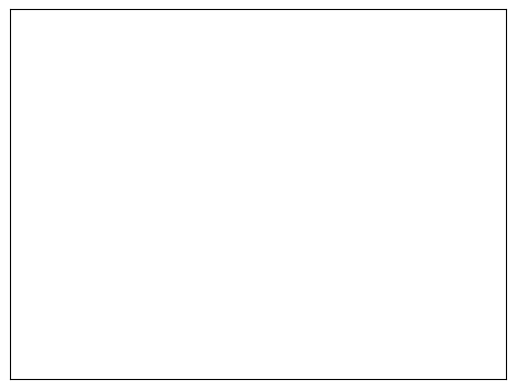

In [77]:
adiciona_padding()